In [1]:
# Import standard libraries
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

2024-12-12 18:15:10.186163: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 18:15:10.188671: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 18:15:10.195803: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733980510.208016  239786 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733980510.211233  239786 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 18:15:10.224709: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
# Load the level 2 asteroid data
core_path = "../asteroid_taxonomy"
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [4]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus_Class"].to_list())

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [47]:
X_train

array([[0.8169, 0.8367, 0.8562, ..., 1.0529, 1.0497, 1.0513],
       [0.9328, 0.9429, 0.9528, ..., 0.9041, 0.9025, 0.9016],
       [0.7924, 0.8112, 0.8304, ..., 1.0229, 1.0181, 1.0153],
       ...,
       [1.0139, 1.0074, 1.0006, ..., 1.0262, 1.0294, 1.0336],
       [0.8821, 0.8932, 0.9042, ..., 0.8627, 0.8524, 0.8422],
       [0.963 , 0.966 , 0.9691, ..., 0.937 , 0.9348, 0.9335]])

In [6]:
# standardscaler and expanding dims

# Instantiate the StandardScaler (mean 0, standard deviation 1)
scaler = preprocessing.StandardScaler().fit(X_train)


X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [7]:
# building the model
n_inputs = asteroids_X.shape[1]

# Let's create an autoencoder with a 2-D latent space
n_bottleneck = 5

def create_model():

    # Input layer, without a normalisation layer standard to autoencoders
    input_layer = keras.Input(shape=(n_inputs, 1))

    # Conv Layers
    hidden_layer = keras.layers.Conv1D(filters=16,
                                       activation="relu",
                                       kernel_size=3, padding="same")(input_layer)
    hidden_layer = keras.layers.Conv1D(filters=32,
                                       activation="relu",
                                       kernel_size=3, padding="same")(hidden_layer)

    # Encoder ("Bottleneck" of the Autoencoder)
    bottleneck_lay = keras.layers.Flatten()(hidden_layer)
    bottleneck_lay = keras.layers.Dense(n_bottleneck)(bottleneck_lay)

    # The original shape must be restored and reshaped accordingly
    reset_lay = keras.layers.Dense(49*32)(bottleneck_lay)
    reshape_lay = keras.layers.Reshape((49, 32))(reset_lay)

    # First and second hidden decoder layers
    hidden_layer = keras.layers.Conv1DTranspose(filters=32,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(reshape_lay)
    hidden_layer = keras.layers.Conv1DTranspose(filters=16,
                                                kernel_size=3,
                                                strides=1,
                                                activation="relu",
                                                padding="same")(hidden_layer)

    # Ouput layer (same size as input layer)
    output_layer = keras.layers.Conv1D(1, 1, padding="same")(hidden_layer)

    # Create model
    model = keras.models.Model(inputs=input_layer, outputs=output_layer)

    # Create encoder model
    encoder_model = keras.models.Model(inputs=input_layer, outputs=bottleneck_lay)

    # We return the model and the encoder
    return model, encoder_model

model, encoder_model = create_model()

# Compile the model and use a regression loss function
model.compile(optimizer='adam', loss='mse')

# Show the model summary
model.summary()

W0000 00:00:1733979547.047426  222136 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 49, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 49, 16)         │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 49, 32)         │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         7,845 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1568)           │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 49, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose                │ (None, 49, 32)         │         3,104 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_1              │ (None, 49, 16)         │         1,552 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 49, 1)          │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,558 (92.02 KB)

 Trainable params: 23,558 (92.02 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    callbacks=[es_callback])

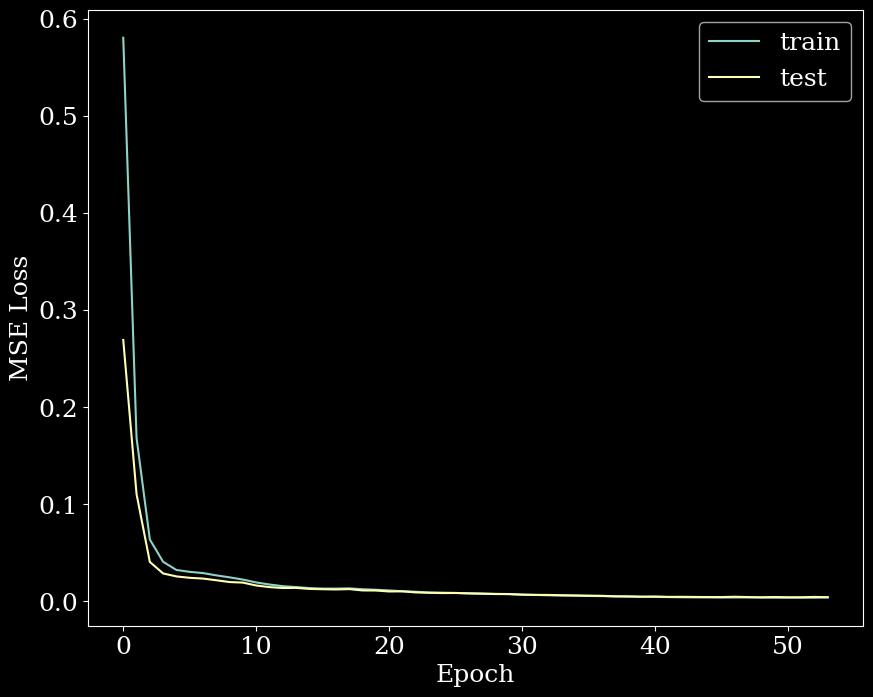

In [9]:
# loss function
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


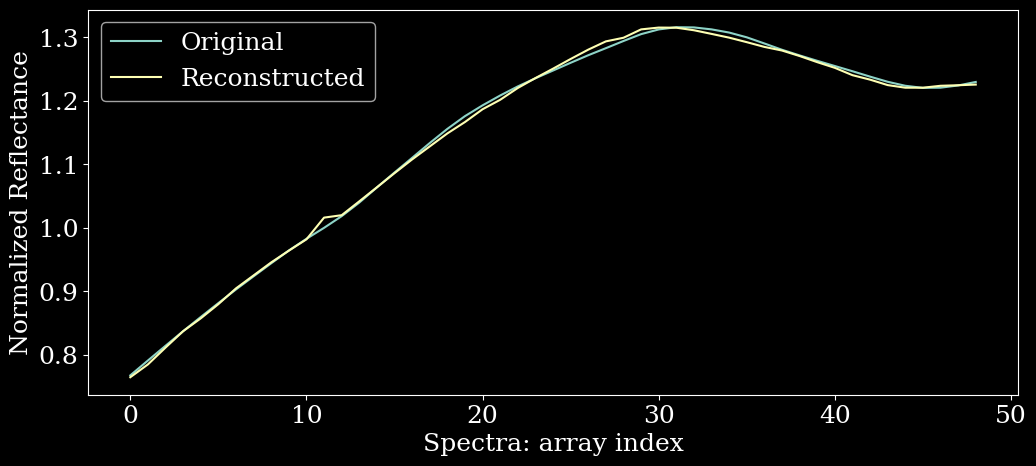

In [10]:
# reconstructing signals

index_val = 7

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]


# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")
plt.show()

In [11]:
# clustering autoencoder forming a datafram for GMMs

# Encode the spectra
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))

# Instantiate the StandardScaler
enc_scaler = preprocessing.StandardScaler().fit(X_encoded)

# Transform now the encoded data
X_encoded_scaled = enc_scaler.transform(X_encoded)

# Merge the classes
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create a column names array for the encoded space
encoder_space = [f"enc{enc_nr+1}" for enc_nr in range(n_bottleneck)]
encoder_space_cols = encoder_space.copy()
encoder_space.extend(["Main_Group", "Bus_Class"])

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded_scaled,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=encoder_space)

# Change the dtype to float
encoded_df.loc[:, encoder_space[:-2]] = encoded_df.loc[:, encoder_space[:-2]].astype(float)

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step


In [14]:
import sklearn.mixture
import tqdm

# Result dataframe contain the number of Gaussian components, the Bayesion Information
# Criterion (BIC) and the model itself
gmm_results_df = pd.DataFrame([], columns=["Nr_Comp", "BIC", "Model"])

# iterate through a number of "component guesses"
max_gauss = 15
for index, gauss_components in tqdm.tqdm(enumerate(np.arange(1, max_gauss+1, 1))):

    # Create and fit a temporary Gaussian Mixture Model
    temp_gmm = sklearn.mixture.GaussianMixture(n_components=gauss_components,
                                               covariance_type="full")
    temp_gmm.fit(X_encoded_scaled)

    # Store the number of components, the BIC and the model
    gmm_results_df.loc[index, "Nr_Comp"] = gauss_components
    gmm_results_df.loc[index, "BIC"] = temp_gmm.bic(X_encoded_scaled)
    gmm_results_df.loc[index, "Model"] = temp_gmm

15it [00:00, 21.49it/s]


(1.0, 15.0)

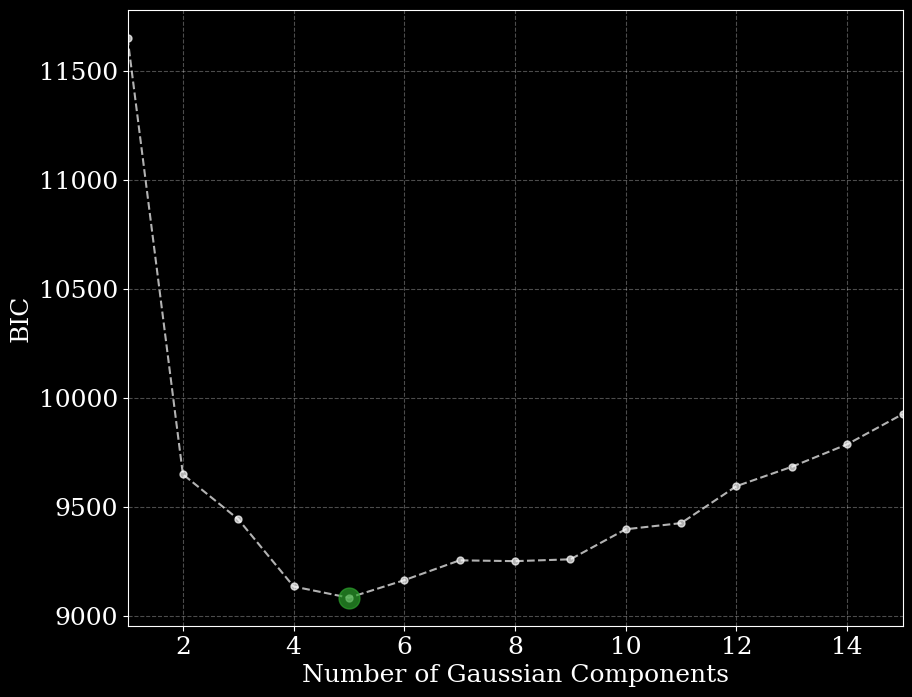

In [15]:
# Plotting the BIC vs. the number of components
plt.figure(figsize=(10, 8))

plt.plot(gmm_results_df["Nr_Comp"],
         gmm_results_df["BIC"],
         linestyle="dashed",
         marker="o",
         markersize=5,
         color="w",
         alpha=0.7)

# Color the minimum value
gmm_results_best = gmm_results_df.loc[gmm_results_df["BIC"] == gmm_results_df["BIC"].min()]
plt.plot(gmm_results_best["Nr_Comp"],
         gmm_results_best["BIC"],
         marker="o",
         markersize=15,
         color="tab:green",
         alpha=0.7)

plt.xlabel("Number of Gaussian Components")
plt.ylabel("BIC")
plt.grid(linestyle="dashed", alpha=0.3)
plt.xlim(1, max_gauss)

In [16]:
# best GMMs
best_gmm = gmm_results_best["Model"].iloc[0]

# Create a new dataframe column that labels the spectra based on our GMM model:
encoded_df.loc[:, "GMM_Class"] = best_gmm.predict(encoded_df[encoder_space_cols].values)

encoded_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class
0,0.997215,-0.436406,0.355061,0.644113,-0.476714,S,S,0
1,-1.156939,0.237399,-1.934856,-1.266731,0.781181,C,C,4
2,0.933381,-0.971912,0.277173,0.755777,-0.975388,S,S,0
3,-0.116771,-0.713124,-0.058237,0.529891,-0.389178,S,S,0
4,0.167042,1.267876,-0.601217,-0.637882,0.783719,X,X,4
...,...,...,...,...,...,...,...,...
1336,0.919892,-1.047497,0.508071,1.343221,-1.65387,S,Sa,1
1337,0.488328,1.033502,1.202201,1.552139,-0.612326,Other,T,1
1338,-1.059345,0.607394,-0.44225,-0.308846,0.893528,X,Xe,4
1339,0.313648,0.946885,0.355306,-0.016744,-0.022739,X,Xk,4


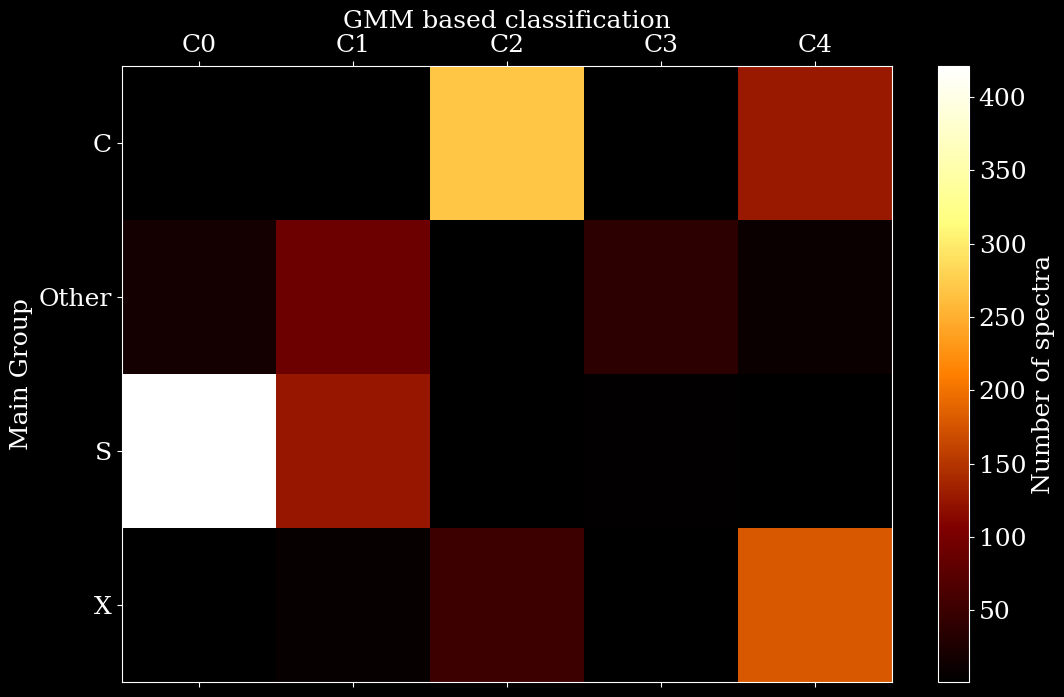

In [17]:
# gmm based confusion matrix

encoded_grouped_df = pd.crosstab(index=encoded_df["Main_Group"],
                                 columns=encoded_df["GMM_Class"],
                                 values=encoded_df["enc1"],
                                 aggfunc="count")

# Extract data, column and index names for plotting purposes
encoded_grouped_values = encoded_grouped_df.values
encoded_grouped_main = encoded_grouped_df.index.values
encoded_grouped_gmm = [f"C{k}" for k in encoded_grouped_df.columns.values]

# Create a matrix-like plot of the results
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(encoded_grouped_values, cmap="afmhot")
fig.colorbar(cax, label="Number of spectra", fraction=0.05)

ax.set_xticks(range(len(encoded_grouped_gmm)))
ax.set_yticks(range(len(encoded_grouped_main)))
ax.set_xticklabels(encoded_grouped_gmm)
ax.set_yticklabels(encoded_grouped_main)

ax.set_xlabel("GMM based classification")
ax.set_ylabel("Main Group")
ax.xaxis.set_label_position('top')

In [ ]:
# now checking the pval for a gaussian distribution or not

In [42]:
# check for corresponding GMM class
encoded_main_s_df = encoded_df.loc[encoded_df["Main_Group"] == "S"].copy()

encoded_main_s_df.groupby("GMM_Class").count()

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class
GMM_Class,,,,,,,
0,421,421,421,421,421,421,421
1,125,125,125,125,125,125,125
2,1,1,1,1,1,1,1
3,3,3,3,3,3,3,3


In [43]:
# probability of each laten vector
encoded_grouped_gmm_prob = [f"C{k}Prob" for k in encoded_grouped_df.columns.values]

encoded_main_s_df.loc[:, encoded_grouped_gmm_prob] = \
    best_gmm.predict_proba(encoded_main_s_df[encoder_space_cols].values)

encoded_main_s_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class,C0Prob,C1Prob,C2Prob,C3Prob,C4Prob
0,0.997215,-0.436406,0.355061,0.644113,-0.476714,S,S,0,9.764038e-01,0.023596,4.497066e-19,1.696475e-07,1.309562e-08
2,0.933381,-0.971912,0.277173,0.755777,-0.975388,S,S,0,9.688675e-01,0.031132,2.006997e-36,6.156154e-07,3.546381e-16
3,-0.116771,-0.713124,-0.058237,0.529891,-0.389178,S,S,0,9.654914e-01,0.034501,3.188498e-19,7.930527e-06,9.656455e-10
6,0.903559,0.165511,0.113715,1.175019,-1.338691,S,S,1,1.039261e-09,1.000000,1.622213e-56,2.103130e-09,6.842451e-19
7,2.313014,0.319293,1.700062,2.373917,-2.484853,S,Sa,1,6.645779e-10,1.000000,8.923777e-121,5.236692e-20,8.195847e-34
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1323,1.603753,0.074266,1.567522,2.080632,-1.128651,S,Sl,1,1.726305e-02,0.982737,1.286254e-24,1.344776e-10,3.642348e-09
1325,0.487103,-0.747994,0.149827,0.780046,-0.562901,S,S,0,9.827161e-01,0.017281,1.158622e-22,3.056504e-06,1.107813e-11
1326,0.68732,-0.645034,0.634108,1.004024,-0.686101,S,S,0,9.411402e-01,0.058860,2.298466e-21,9.157175e-08,6.151258e-10
1336,0.919892,-1.047497,0.508071,1.343221,-1.65387,S,Sa,1,1.369515e-01,0.863048,2.193177e-61,4.437558e-07,3.788882e-25


Text(0, 0.5, 'Number of spectra')

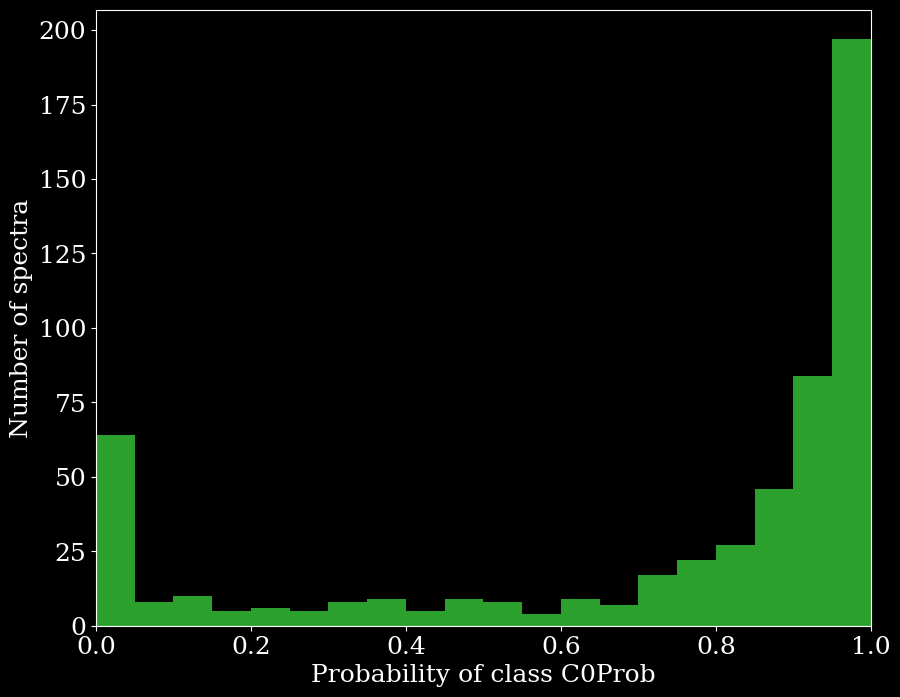

In [44]:
# histograms
gmm_cl = "C0Prob"

# Let's plot the probability distribution
plt.figure(figsize=(10, 8))

plt.hist(encoded_main_s_df[gmm_cl], bins=np.arange(0, 1.1, 0.05), color="tab:green")

plt.xlim(0, 1)

plt.xlabel(f"Probability of class {gmm_cl}")
plt.ylabel("Number of spectra")

In [45]:
# spectra most likely linked to gaussian with >= 0.95
encoded_main_s_df = encoded_main_s_df.loc[encoded_main_s_df[gmm_cl] >= 0.95]

encoded_main_s_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class,C0Prob,C1Prob,C2Prob,C3Prob,C4Prob
0,0.997215,-0.436406,0.355061,0.644113,-0.476714,S,S,0,0.976404,0.023596,4.497066e-19,1.696475e-07,1.309562e-08
2,0.933381,-0.971912,0.277173,0.755777,-0.975388,S,S,0,0.968867,0.031132,2.006997e-36,6.156154e-07,3.546381e-16
3,-0.116771,-0.713124,-0.058237,0.529891,-0.389178,S,S,0,0.965491,0.034501,3.188498e-19,7.930527e-06,9.656455e-10
16,1.020265,-0.199881,0.750036,0.72011,-0.499583,S,S,0,0.952200,0.047797,5.915321e-16,2.443089e-09,2.701700e-06
17,1.04238,-0.637638,0.153809,0.927636,-0.613348,S,S,0,0.960683,0.039302,5.950769e-25,1.507877e-05,2.691328e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,0.823851,-0.738736,0.540695,0.902856,-0.607473,S,S,0,0.954011,0.045989,4.814450e-21,3.681592e-07,5.181710e-10
1294,0.701417,-1.355855,-0.118086,0.469821,-0.687924,S,S,0,0.981221,0.018724,1.529871e-33,5.480788e-05,1.577894e-16
1312,0.061765,-0.509806,-0.305692,0.064611,-0.004953,S,Sk,0,0.987477,0.012510,1.517122e-12,1.131730e-05,2.329187e-06
1320,-0.12882,-0.342761,-0.152864,-0.092903,0.295239,S,Sk,0,0.970102,0.026699,1.520250e-07,2.749809e-06,3.195566e-03


In [46]:
# mutlivariate normality for distribution
import pingouin

encoded_main_s = np.array(encoded_main_s_df[encoder_space_cols].values, dtype="float64")
pingouin.multivariate_normality(encoded_main_s)

HZResults(hz=np.float64(1.0738028492783787), pval=np.float64(0.005998561705109311), normal=False)

In [30]:
# normal is False and the pval is really low meaning probability is low for a gaussian distribution